## VTC Evaluation Steps

In [ ]:
import logging
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from pyannote.core import Annotation, Segment, Timeline
from pyannote.metrics.detection import DetectionPrecisionRecallFMeasure, DetectionErrorRate
from pyannote.database.util import load_uem
from typing import List
from src.constants import VTCPaths

def plot_annotations_vs_predictions(audio_file_name: str, hypothesis_type: str, time_window: list) -> None:
    """
    Plot ground truth annotations and model predictions for a given audio file and time window.

    Parameters
    ----------
    audio_file_name : str
        The name of the audio file
    hypothesis_type : str
        Hypothesis type: 'og', 'ft', or 'cl'.
    time_window : list
        Start and end time for the plot: [start_time, end_time].
    """
    if hypothesis_type == 'cl_v2':
        gt_df = pd.read_pickle("/home/nele_pauline_suffo/ProcessedData/childlens_annotations/processed/childlens_annotations_gt_v2.pkl")
    else:
        gt_df = pd.read_pickle(VTCPaths.childlens_gt_df_file_path)

    hypothesis_paths = {
        'og_01': Path('/home/nele_pauline_suffo/outputs/vtc/childlens_df_og_01.pkl'),
        'og_2': Path('/home/nele_pauline_suffo/outputs/vtc/childlens_df_og_2.pkl'),
        'ft_01': Path('/home/nele_pauline_suffo/outputs/vtc_finetuned/childlens_df_ft_01.pkl'),
        'ft_2': Path('/home/nele_pauline_suffo/outputs/vtc_finetuned/childlens_df_ft_2.pkl'),
        'cl_01': Path('/home/nele_pauline_suffo/outputs/vtc_from_scratch/childlens_df_cl_01.pkl'),
        'cl_2': Path('/home/nele_pauline_suffo/outputs/vtc_from_scratch/childlens_df_cl_2.pkl'),
        'cl_v2': Path('/home/nele_pauline_suffo/outputs/vtc_from_scratch/childlens_df_cl_v2.pkl'),
    }
    if hypothesis_type not in hypothesis_paths:
        raise ValueError("Invalid hypothesis type. Choose from 'og', 'ft', or 'cl'.")

    hypothesis_df = pd.read_pickle(hypothesis_paths[hypothesis_type])
    # Normalize labels
    hypothesis_df['Voice_type'] = hypothesis_df['Voice_type'].str.upper()
    
    # Filter relevant audio file
    gt = gt_df[gt_df['audio_file_name'] == audio_file_name]
    pred = hypothesis_df[hypothesis_df['audio_file_name'] == audio_file_name]

    if hypothesis_type == 'cl_v2':
        voice_types = ['KCHI', 'CDS', 'OHS']
    else:
        voice_types = ['KCHI', 'CHI', 'FEM', 'MAL', 'SPEECH']
    colors = {'GT': 'green', 'Pred': 'blue'}

    # Set up the plot
    plt.figure(figsize=(10, 2.75))  # Increased height for more vertical space
    ax = plt.gca()

    row_step = 2  # Increase this value to add more vertical spacing
    yticks = []
    ylabels = []

    for i, vt in enumerate(voice_types[::-1]):  # Reverse order for stacking
        base_y = i * row_step
        for offset, (source_df, label_prefix) in enumerate([(gt, 'GT'), (pred, 'Pred')]):
            y_pos = base_y + offset
            for _, row in source_df[source_df['Voice_type'] == vt].iterrows():
                ax.barh(
                    y=y_pos,
                    width=row['Utterance_Duration'],
                    left=row['Utterance_Start'],
                    color=colors[label_prefix],
                    edgecolor='black',
                    alpha=0.7
                )
            yticks.append(y_pos)
            ylabels.append(f"{label_prefix} {vt}")

    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Category")
    ax.set_title("Annotations vs Predictions")
    ax.set_xlim(time_window[0], time_window[1])
    ax.set_ylim(-1, max(yticks) + 2)
    plt.tight_layout()
    plt.show()
    
def combine_pickles(folder_path: str, output_file_name: str) -> None:
    """
    Combines all pickle files in a folder into a single DataFrame and saves it to a new pickle file.

    Parameters:
    - folder_path (str): Path to the folder containing the pickle files.
    - output_path (str): Path to save the combined DataFrame as a pickle file.
    """
    # List to store individual DataFrames
    dataframes = []

    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.pkl'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'rb') as f:
                df = pickle.load(f)
                dataframes.append(df)

    # Combine all DataFrames into one
    combined_df = pd.concat(dataframes, ignore_index=True)

    output_path = os.path.join(folder_path, output_file_name)
    combined_df.to_pickle(output_path)
    
def rttm_to_dataframe(rttm_file: Path, output_path: Path) -> pd.DataFrame:
    """
    This function reads the voice_type_classifier
    output rttm file and returns its content as a pandas DataFrame.

    Parameters
    ----------
    rttm_file : path
        the path to the RTTM file
    output_path: path
        the path to the output pkl file

    """
    logging.info(f"Reading RTTM file from: {rttm_file}")
    
    try:
        df = pd.read_csv(
            rttm_file,
            sep=" ",
            names=[
                "Speaker",
                "audio_file_name",
                "audio_file_id",
                "Utterance_Start",
                "Utterance_Duration",
                "NA_1",
                "NA_2",
                "Voice_type",
                "NA_3",
                "NA_4",
            ],
        )
    except Exception as e:
        logging.error(f"Failed to read RTTM file: {e}")
        raise
    
    logging.info("Successfully read RTTM file. Processing data...")

    # Drop unnecessary columns
    df = df.drop(columns=["Speaker", "audio_file_id", "NA_1", "NA_2", "NA_3", "NA_4"])  # noqa: E501
    df["Utterance_End"] = df["Utterance_Start"] + df["Utterance_Duration"]
    
    logging.info("Data processing complete. Returning DataFrame.")

    try:
        df.to_pickle(output_path)
        logging.info(f"DataFrame successfully saved to: {output_path}")
    except Exception as e:
        logging.error(f"Failed to save DataFrame to file: {e}")
        raise

def dataframe_to_annotation(df, label_column="Voice_type"):
    """
    Converts a DataFrame to a pyannote.core.Annotation object.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with 'Utterance_Start', 'Utterance_End', and a label column.
    - label_column (str): Column name for the labels (default: 'Voice_type').

    Returns:
    - Annotation: pyannote.core.Annotation object.
    """
    annotation = Annotation()
    for _, row in df.iterrows():
        start = float(row["Utterance_Start"])
        end = float(row["Utterance_End"])
        label = row[label_column]
        annotation[Segment(start, end)] = label
    return annotation

def compute_metrics(hypothesis_type: str) -> None:
    """
    Computes and prints the detection metrics for the given hypothesis type.
    Parameters
    ----------
    hypothesis_type : str
        The type of hypothesis to compute metrics for. Options are 'og', 'ft', or 'cl'.
    """
    hypothesis_paths = {
        'og_01': Path('/home/nele_pauline_suffo/outputs/vtc/childlens_df_og_01.pkl'),
        'og_2': Path('/home/nele_pauline_suffo/outputs/vtc/childlens_df_og_2.pkl'),
        'ft_01': Path('/home/nele_pauline_suffo/outputs/vtc_finetuned/childlens_df_ft_01.pkl'),
        'ft_2': Path('/home/nele_pauline_suffo/outputs/vtc_finetuned/childlens_df_ft_2.pkl'),
        'cl_01': Path('/home/nele_pauline_suffo/outputs/vtc_from_scratch/childlens_df_cl_01.pkl'),
        'cl_2': Path('/home/nele_pauline_suffo/outputs/vtc_from_scratch/childlens_df_cl_2.pkl'),
        'cl_v2': Path('/home/nele_pauline_suffo/outputs/vtc_from_scratch/childlens_df_cl_v2.pkl'),
    }
    if hypothesis_type not in hypothesis_paths:
        raise ValueError("Invalid hypothesis type. Choose 'og', 'ft', or 'cl'.")
    
    hypothesis_path = hypothesis_paths[hypothesis_type]

    if hypothesis_type == "cl_v2":
        reference_df = pd.read_pickle("/home/nele_pauline_suffo/ProcessedData/childlens_annotations/processed/childlens_annotations_gt_v2.pkl")
    else:
        reference_df = pd.read_pickle(VTCPaths.childlens_gt_df_file_path)
    hypothesis_df = pd.read_pickle(hypothesis_path)
    
    # Normalize labels
    reference_df['Voice_type'] = reference_df['Voice_type'].replace({'OCH': 'CHI'})
    hypothesis_df['Voice_type'] = hypothesis_df['Voice_type'].str.upper().replace({'OCH': 'CHI'})

    # Find common audio_file_names present in both reference and hypothesis
    reference_files_set = set(reference_df['audio_file_name'].unique())
    hypothesis_files_set = set(hypothesis_df['audio_file_name'].unique())
    
    annotated_files = list(reference_files_set.intersection(hypothesis_files_set))
    
    if not annotated_files:
        print(f"Warning: No common audio files found between reference and hypothesis for type '{hypothesis_type}'. Metrics cannot be computed.")
        return

    # Filter both DataFrames to only include these common files
    # This ensures that when we iterate through annotated_files, both DFs will have entries for that file.
    reference_df = reference_df[reference_df['audio_file_name'].isin(annotated_files)]
    predictions_df = hypothesis_df[hypothesis_df['audio_file_name'].isin(annotated_files)]
    
    # Define the UEM file path and load it once before the loop
    uem_file_path = "/home/nele_pauline_suffo/ProcessedData/vtc_childlens/complete.uem"
    try: 
        all_video_uems = load_uem(uem_file_path)
    except FileNotFoundError:
        print(f"Warning: UEM file not found at {uem_file_path}. UEM will be approximated.")
        all_video_uems = {}
    except Exception as e:
        print(f"Warning: Error loading UEM file {uem_file_path}: {e}. UEM will be approximated.")
        all_video_uems = {}

    if hypothesis_type == 'cl_v2':
        voice_types = ['KCHI', 'CDS', 'OHS']
    else:
        voice_types = ['KCHI', 'CHI', 'FEM', 'MAL', 'SPEECH']
    metric_names = ['precision', 'recall', 'f1_score', 'error_rate']
    
    # More compact initialization for class_metrics
    class_metrics_results = {
        vt: {metric_name: [] for metric_name in metric_names}
        for vt in voice_types
    }

    for video_filename in annotated_files:
        ref_video_df = reference_df[reference_df['audio_file_name'] == video_filename]
        pred_video_df = predictions_df[predictions_df['audio_file_name'] == video_filename]

        if ref_video_df.empty:
            # This case should ideally not happen if annotated_files is derived from reference_df
            print(f"Warning: No reference annotations found for video: {video_filename}, though it was in annotated_files. Skipping.")
            continue
        # Get the UEM Timeline for the current video_filename
        # Ensure video_filename matches the URI key in the UEM file
        current_video_uem: Optional[Timeline] = all_video_uems.get(video_filename)
        if current_video_uem is None:
            # This print is optional, as pyannote will warn if it approximates
            print(f"Info: No UEM entry found for {video_filename} in {uem_file_path} . UEM will be approximated for this file.")
            pass
        
        for voice_type in voice_types:
            ref_class_video_df = ref_video_df[ref_video_df['Voice_type'] == voice_type]
            pred_class_video_df = pred_video_df[pred_video_df['Voice_type'] == voice_type]

            reference_annotation = dataframe_to_annotation(ref_class_video_df)
            hypothesis_annotation = dataframe_to_annotation(pred_class_video_df)

            # Initialize metric objects for each video-class pair to get non-accumulated scores
            detection_pr_f1_metric = DetectionPrecisionRecallFMeasure(collar=0, skip_overlap=False)
            detection_error_metric = DetectionErrorRate(collar=0, skip_overlap=False)

            # Compute metrics
            _ = detection_pr_f1_metric(reference_annotation, hypothesis_annotation, uem=current_video_uem)
            p, r, f1 = detection_pr_f1_metric.compute_metrics()
            error_rate = detection_error_metric(reference_annotation, hypothesis_annotation, uem=current_video_uem)

            class_metrics_results[voice_type]['precision'].append(p)
            class_metrics_results[voice_type]['recall'].append(r)
            class_metrics_results[voice_type]['f1_score'].append(f1)
            class_metrics_results[voice_type]['error_rate'].append(error_rate)

    print(f"\nAveraged Metrics Per Class Over All Videos (Hypothesis: {hypothesis_type.upper()}):")
    
    overall_macro_f1_components = []

    for voice_type in voice_types:
        print(f"Class '{voice_type.upper()}':")
        for metric_name in metric_names:
            metric_values = class_metrics_results[voice_type][metric_name]
            
            # Filter out NaN values before averaging
            valid_metric_values = [v for v in metric_values if not pd.isna(v)]
            
            if valid_metric_values:
                avg_metric = sum(valid_metric_values) / len(valid_metric_values)
            else:
                avg_metric = 0.0  # Or float('nan') if you prefer to show NaN for no valid scores

            print(f"  Average {metric_name.replace('_', ' ').capitalize()}: {avg_metric:.3f}")
            
            if metric_name == 'f1_score':
                overall_macro_f1_components.append(avg_metric)
        print("") # Newline for readability between classes

    if overall_macro_f1_components:
        final_macro_f1_score = sum(overall_macro_f1_components) / len(overall_macro_f1_components)
    else:
        final_macro_f1_score = 0.0 # Or float('nan')

    print(f"Final Macro F1 Score (average of per-class average F1 scores): {final_macro_f1_score:.3f}")

def compute_all_metrics_table() -> pd.DataFrame:
    """
    Computes detection metrics for all predefined hypothesis setups and returns them as a pandas DataFrame.

    Returns
    -------
    pd.DataFrame
        A DataFrame where rows are hypothesis types and columns are metrics 
        (e.g., KCHI_precision, KCHI_recall, ..., Macro_F1_Score).
    """
    all_hypothesis_types = ['og_01', 'og_2', 'ft_01', 'ft_2', 'cl_01', 'cl_2']
    
    hypothesis_paths_config = {
        'og_01': Path('/home/nele_pauline_suffo/outputs/vtc/childlens_df_og_01.pkl'),
        'og_2': Path('/home/nele_pauline_suffo/outputs/vtc/childlens_df_og_2.pkl'),
        'ft_01': Path('/home/nele_pauline_suffo/outputs/vtc_finetuned/childlens_df_ft_01.pkl'),
        'ft_2': Path('/home/nele_pauline_suffo/outputs/vtc_finetuned/childlens_df_ft_2.pkl'),
        'cl_01': Path('/home/nele_pauline_suffo/outputs/vtc_from_scratch/childlens_df_cl_01.pkl'),
        'cl_2': Path('/home/nele_pauline_suffo/outputs/vtc_from_scratch/childlens_df_cl_2.pkl')
    }

    reference_df_global = pd.read_pickle(VTCPaths.childlens_gt_df_file_path)

    uem_file_path = "/home/nele_pauline_suffo/ProcessedData/vtc_childlens/complete.uem"
    try:
        all_video_uems_global = load_uem(uem_file_path)
    except FileNotFoundError:
        print(f"Warning: Global UEM file not found at {uem_file_path}. UEM will be approximated for all files.")
        all_video_uems_global = {}
    except Exception as e:
        print(f"Warning: Error loading global UEM file {uem_file_path}: {e}. UEM will be approximated for all files.")
        all_video_uems_global = {}

    voice_types = ['KCHI', 'CHI', 'FEM', 'MAL', 'SPEECH']
    metric_names = ['precision', 'recall', 'f1_score', 'error_rate']
    
    collected_results = []

    for hypothesis_type in all_hypothesis_types:
        print(f"\nProcessing hypothesis: {hypothesis_type.upper()}")
        
        hypothesis_path = hypothesis_paths_config[hypothesis_type]
        try:
            hypothesis_df_original = pd.read_pickle(hypothesis_path)
        except FileNotFoundError:
            print(f"Warning: Hypothesis file not found for {hypothesis_type} at {hypothesis_path}. Skipping this hypothesis.")
            # Add a row of NaNs or skip
            row_data = {'Hypothesis': hypothesis_type}
            for vt in voice_types:
                for mn in metric_names:
                    row_data[f"{vt}_{mn}"] = np.nan
            row_data['Macro_F1_Score'] = np.nan
            collected_results.append(row_data)
            continue

        # Create copies to avoid modifying dataframes in loop
        reference_df = reference_df_global.copy()
        hypothesis_df = hypothesis_df_original.copy()

        # Normalize hypothesis labels
        hypothesis_df['Voice_type'] = hypothesis_df['Voice_type'].str.upper().replace({'OCH': 'CHI'})

        reference_files_set = set(reference_df['audio_file_name'].unique())
        hypothesis_files_set = set(hypothesis_df['audio_file_name'].unique())
        annotated_files = list(reference_files_set.intersection(hypothesis_files_set))

        if not annotated_files:
            print(f"Warning: No common audio files found between reference and hypothesis for type '{hypothesis_type}'. Metrics will be NaN.")
            row_data = {'Hypothesis': hypothesis_type}
            for vt in voice_types:
                for mn in metric_names:
                    row_data[f"{vt}_{mn}"] = np.nan
            row_data['Macro_F1_Score'] = np.nan
            collected_results.append(row_data)
            continue

        # Filter DataFrames
        reference_df = reference_df[reference_df['audio_file_name'].isin(annotated_files)]
        predictions_df = hypothesis_df[hypothesis_df['audio_file_name'].isin(annotated_files)]

        class_metrics_results = {
            vt: {metric_name: [] for metric_name in metric_names}
            for vt in voice_types
        }

        for video_filename in annotated_files:
            ref_video_df = reference_df[reference_df['audio_file_name'] == video_filename]
            pred_video_df = predictions_df[predictions_df['audio_file_name'] == video_filename]

            if ref_video_df.empty:
                # This case should ideally not happen if annotated_files is derived from reference_df
                print(f"Warning: No reference annotations found for video: {video_filename} in {hypothesis_type}. Skipping this video for this hypothesis.")
                continue
            
            current_video_uem: Optional[Timeline] = all_video_uems_global.get(video_filename)
            if current_video_uem is None and video_filename in all_video_uems_global: # Check if key existed but was None
                 print(f"Info: UEM entry for {video_filename} was None. Approximating for this file.")
            elif current_video_uem is None: # Key did not exist
                 print(f"Info: No UEM entry found for {video_filename} in {uem_file_path}. UEM will be approximated for this file.")


            for voice_type in voice_types:
                ref_class_video_df = ref_video_df[ref_video_df['Voice_type'] == voice_type]
                pred_class_video_df = pred_video_df[pred_video_df['Voice_type'] == voice_type]

                reference_annotation = dataframe_to_annotation(ref_class_video_df)
                hypothesis_annotation = dataframe_to_annotation(pred_class_video_df)

                detection_pr_f1_metric = DetectionPrecisionRecallFMeasure(collar=0, skip_overlap=False)
                detection_error_metric = DetectionErrorRate(collar=0, skip_overlap=False)

                _ = detection_pr_f1_metric(reference_annotation, hypothesis_annotation, uem=current_video_uem)
                p, r, f1 = detection_pr_f1_metric.compute_metrics()
                error_rate = detection_error_metric(reference_annotation, hypothesis_annotation, uem=current_video_uem)

                class_metrics_results[voice_type]['precision'].append(p)
                class_metrics_results[voice_type]['recall'].append(r)
                class_metrics_results[voice_type]['f1_score'].append(f1)
                class_metrics_results[voice_type]['error_rate'].append(error_rate)
        
        # Averaged metrics for the current hypothesis
        current_hypothesis_metrics = {'Hypothesis': hypothesis_type}
        overall_macro_f1_components = []

        for voice_type in voice_types:
            for metric_name in metric_names:
                metric_values = class_metrics_results[voice_type][metric_name]
                valid_metric_values = [v for v in metric_values if not pd.isna(v)]
                
                avg_metric = np.nan
                if valid_metric_values:
                    avg_metric = sum(valid_metric_values) / len(valid_metric_values)
                else: # No valid scores for this class/metric (e.g. class never appeared in any video)
                    avg_metric = 0.0 # Or np.nan if you prefer to show NaN for no valid scores

                current_hypothesis_metrics[f"{voice_type}_{metric_name}"] = avg_metric
                
                if metric_name == 'f1_score':
                    # Only include in macro average if it's a valid number (not NaN from previous step)
                    # and also consider if 0.0 should contribute or if it means the class was absent.
                    # Pyannote's F1 can be 0 if P or R is 0.
                    # If avg_metric became 0.0 because no valid_metric_values, it means the class was not evaluated.
                    # If it's a calculated 0.0 F1, it should be part of macro average.
                    # For simplicity, we add it if it's not NaN.
                    if not pd.isna(avg_metric):
                         overall_macro_f1_components.append(avg_metric)

        final_macro_f1_score = np.nan
        if overall_macro_f1_components: # Ensure list is not empty
            # Filter out potential NaNs that might have slipped if avg_metric was set to np.nan and not filtered
            valid_f1_components = [f1 for f1 in overall_macro_f1_components if not pd.isna(f1)]
            if valid_f1_components:
                final_macro_f1_score = sum(valid_f1_components) / len(valid_f1_components)
            else: # All per-class F1s were NaN or 0 due to no valid scores
                final_macro_f1_score = 0.0 # Or np.nan
        else: # No classes had valid F1 scores to average
             final_macro_f1_score = 0.0 # Or np.nan

        current_hypothesis_metrics['Macro_F1_Score'] = final_macro_f1_score
        collected_results.append(current_hypothesis_metrics)

    results_df = pd.DataFrame(collected_results)
    if not results_df.empty:
        results_df = results_df.set_index('Hypothesis')
        
        # Define column order for better readability
        columns_ordered = []
        for vt in voice_types:
            for mn in metric_names:
                columns_ordered.append(f"{vt}_{mn}")
        columns_ordered.append('Macro_F1_Score')
        
        # Reorder if all columns exist (handles cases where a hypothesis might have failed to produce some)
        results_df = results_df.reindex(columns=[col for col in columns_ordered if col in results_df.columns])

    return results_df

### 1. Convert Output RTTM to Dataframe

In [10]:
rttm_og_01_file_path = "/home/nele_pauline_suffo/outputs/vtc/childlens_audio_01/all.rttm"
rttm_og_2_file_path = "/home/nele_pauline_suffo/outputs/vtc/childlens_audio_2/all.rttm"
output_og_01_file_path = "/home/nele_pauline_suffo/outputs/vtc/childlens_df_og_01.pkl"
output_og_2_file_path = "/home/nele_pauline_suffo/outputs/vtc/childlens_df_og_2.pkl"

rttm_ft_01_file_path = "/home/nele_pauline_suffo/outputs/vtc_finetuned/childlens_audio_01/all.rttm"
rttm_ft_2_file_path = "/home/nele_pauline_suffo/outputs/vtc_finetuned/childlens_audio_2/all.rttm"
output_ft_01_file_path = "/home/nele_pauline_suffo/outputs/vtc_finetuned/childlens_df_ft_01.pkl"
output_ft_2_file_path = "/home/nele_pauline_suffo/outputs/vtc_finetuned/childlens_df_ft_2.pkl"

rttm_cl_01_file_path = "/home/nele_pauline_suffo/outputs/vtc_from_scratch/childlens_audio_01/all.rttm"
rttm_cl_2_file_path = "/home/nele_pauline_suffo/outputs/vtc_from_scratch/childlens_audio_2/all.rttm"
output_cl_01_file_path = "/home/nele_pauline_suffo/outputs/vtc_from_scratch/childlens_df_cl_01.pkl"
output_cl_2_file_path = "/home/nele_pauline_suffo/outputs/vtc_from_scratch/childlens_df_cl_2.pkl"

rttm_cl_v2_file_path = "/home/nele_pauline_suffo/outputs/vtc_from_scratch/childlens_audio_v2/all.rttm"
output_cl_v2_file_path = "/home/nele_pauline_suffo/outputs/vtc_from_scratch/childlens_df_cl_v2.pkl"

rttm_to_dataframe(rttm_og_01_file_path, output_og_01_file_path)
rttm_to_dataframe(rttm_og_2_file_path, output_og_2_file_path)
rttm_to_dataframe(rttm_ft_01_file_path, output_ft_01_file_path)
rttm_to_dataframe(rttm_ft_2_file_path, output_ft_2_file_path)
rttm_to_dataframe(rttm_cl_01_file_path, output_cl_01_file_path)
rttm_to_dataframe(rttm_cl_2_file_path, output_cl_2_file_path)
rttm_to_dataframe(rttm_cl_v2_file_path, output_cl_v2_file_path)

### 2. Compute Evaluation Metrics

In [21]:
metrics_df = compute_all_metrics_table()


Processing hypothesis: OG_01

Processing hypothesis: OG_2

Processing hypothesis: FT_01

Processing hypothesis: FT_2

Processing hypothesis: CL_01

Processing hypothesis: CL_2


In [22]:
metrics_f1_df = metrics_df[["KCHI_f1_score", "CHI_f1_score", "FEM_f1_score", "MAL_f1_score", "SPEECH_f1_score", "Macro_F1_Score"]]
# multiply by 100 for percentage and show only 2 decimals
# round to 2 decimals
metrics_f1_df = (metrics_f1_df * 100).round(2)
metrics_f1_df

,KCHI_f1_score,CHI_f1_score,FEM_f1_score,MAL_f1_score,SPEECH_f1_score,Macro_F1_Score
Hypothesis,,,,,,
og_01,62.83,5.27,39.37,23.86,77.01,41.67
og_2,68.30,5.42,41.05,25.24,82.21,44.44
ft_01,78.98,10.03,51.98,44.89,86.72,54.52
ft_2,79.33,10.04,53.20,45.46,86.43,54.89
cl_01,78.91,8.09,50.60,51.64,86.83,55.21
cl_2,79.60,7.92,52.21,52.59,86.24,55.71


In [17]:
compute_metrics('cl_v2')


Averaged Metrics Per Class Over All Videos (Hypothesis: CL_V2):
Class 'KCHI':
  Average Precision: 0.814
  Average Recall: 0.797
  Average F1 score: 0.793
  Average Error rate: 0.431

Class 'CDS':
  Average Precision: 1.000
  Average Recall: 1.000
  Average F1 score: 1.000
  Average Error rate: 0.000

Class 'OHS':
  Average Precision: 1.000
  Average Recall: 1.000
  Average F1 score: 1.000
  Average Error rate: 0.000

Final Macro F1 Score (average of per-class average F1 scores): 0.931


## Plot Results

In [20]:
gt_df = pd.read_pickle(VTCPaths.childlens_gt_df_file_path)
gt_df

,audio_file_name,Utterance_Start,Utterance_Duration,Voice_type,Utterance_End
0,205296.MP4,3.471,5.831,SPEECH,9.302
1,205296.MP4,3.471,5.831,SPEECH,9.302
2,205296.MP4,7.729,5.091,KCHI,12.819
3,205296.MP4,7.729,5.091,SPEECH,12.819
4,205296.MP4,14.393,3.795,SPEECH,18.188
...,...,...,...,...,...
48211,467868.MP4,99.706,0.752,SPEECH,100.457
48212,467868.MP4,103.625,2.201,FEM,105.826
48213,467868.MP4,103.625,2.201,SPEECH,105.826
48214,467868.MP4,102.551,3.812,SPEECH,106.363


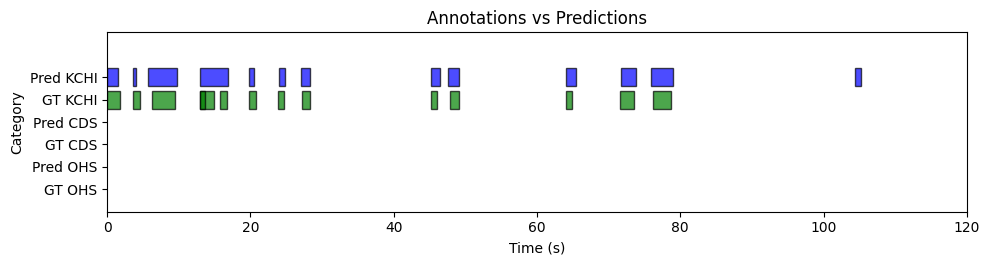

In [19]:
plot_annotations_vs_predictions('100898.MP4', "cl_v2", [0, 120])

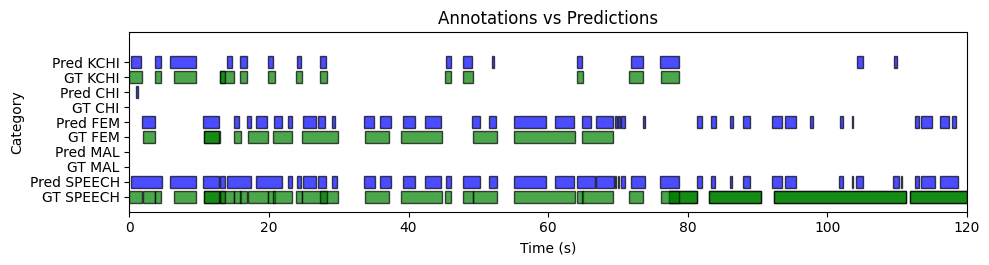

In [ ]:
plot_annotations_vs_predictions('100898.MP4', "og_01", [0, 120])

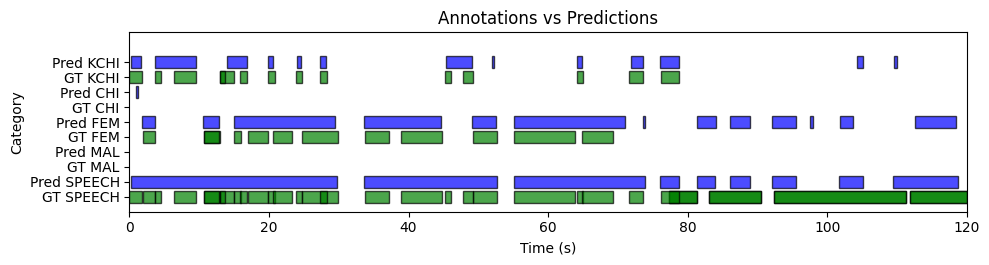

In [17]:
plot_annotations_vs_predictions('100898.MP4', "og_2", [0, 120])

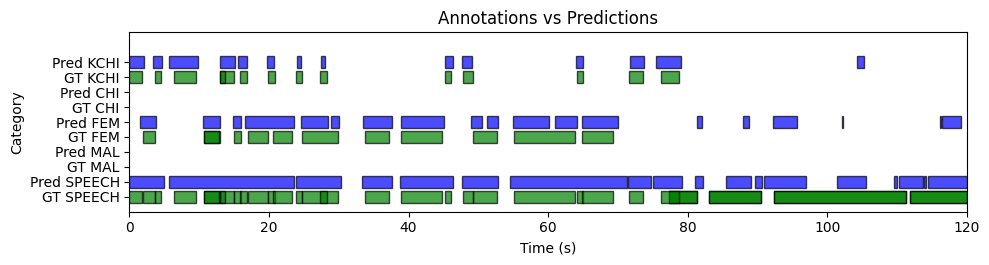

In [18]:
plot_annotations_vs_predictions('100898.MP4', "ft_01", [0, 120])

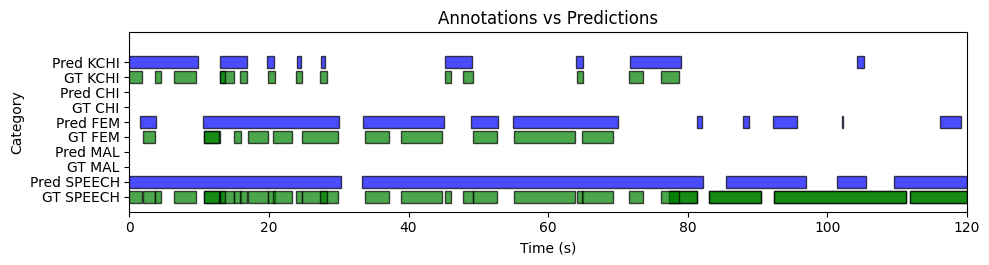

In [19]:
plot_annotations_vs_predictions('100898.MP4', "ft_2", [0, 120])

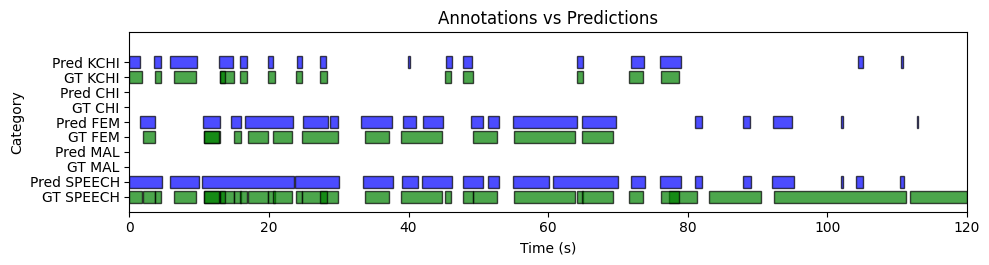

In [48]:
plot_annotations_vs_predictions('100898.MP4', "cl", [0, 120])

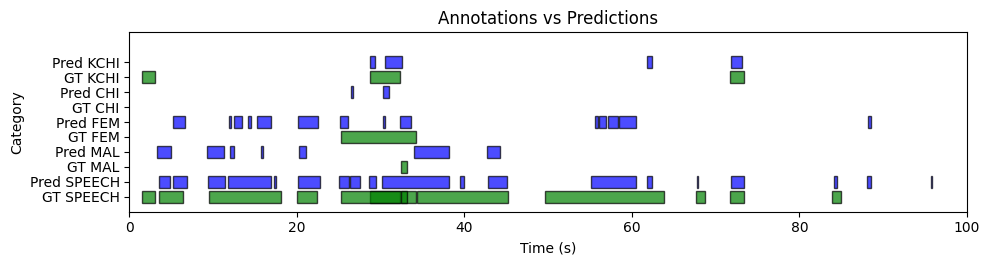

In [43]:
plot_annotations_vs_predictions('410731.MP4', "og", [0, 100])

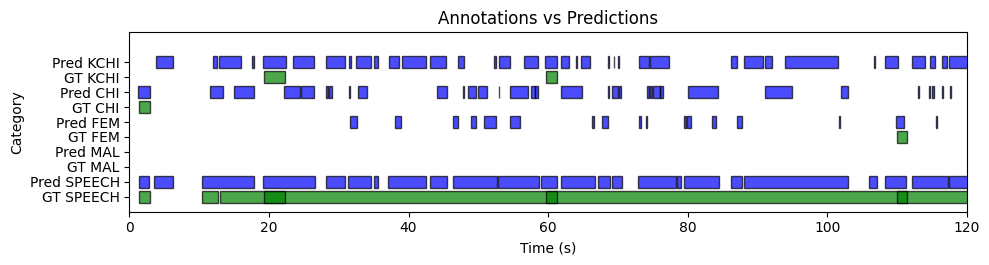

In [44]:
plot_annotations_vs_predictions('336244.MP4', "og", [0, 120])

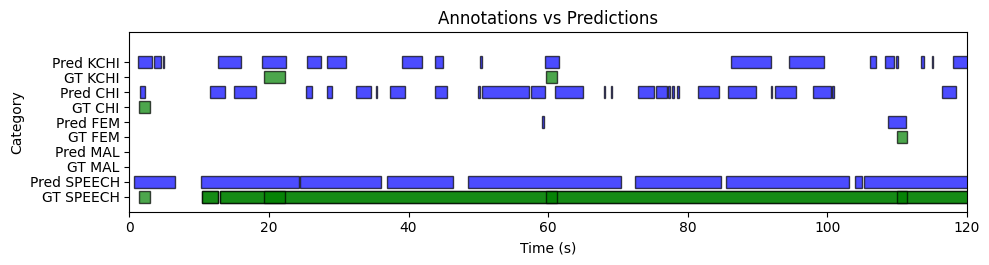

In [3]:
plot_annotations_vs_predictions('336244.MP4', "ft", [0, 120])

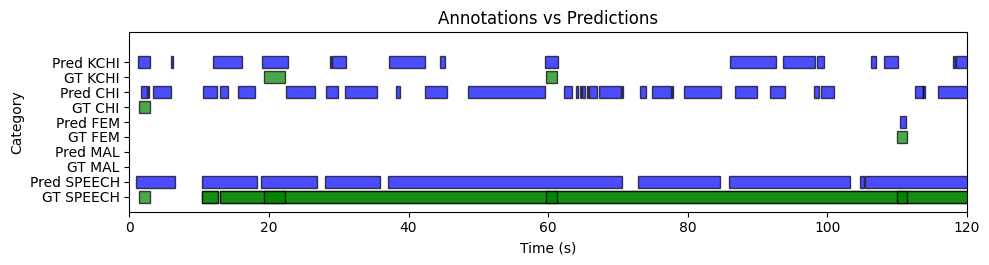

In [7]:
plot_annotations_vs_predictions('336244.MP4', "cl_01", [0, 120])

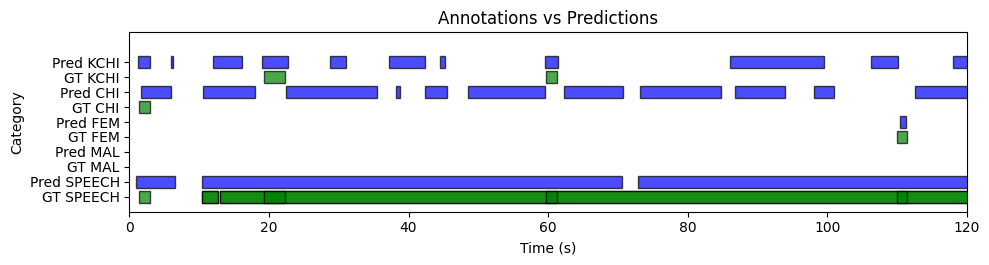

In [8]:
plot_annotations_vs_predictions('336244.MP4', "cl_2", [0, 120])

### Length of each Voice Type Class

In [3]:
gt_df = pd.read_pickle(VTCPaths.childlens_gt_df_file_path)
# sum utterance durations for each Voice_type in minutes (divide by 60)
gt_df.groupby('Voice_type')['Utterance_Duration'].sum() / 60

Voice_type
CHI         43.977633
FEM        455.907233
KCHI       859.266517
MAL        200.408267
SPEECH    2361.872283
Name: Utterance_Duration, dtype: float64

### Utils: Convert audio to 16khz sampling rate

In [ ]:
import os
from pathlib import Path
from pydub import AudioSegment
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

def convert_to_16khz(input_folder: Path, output_folder: Path) -> None:
    """Convert all audio files in a folder to 16kHz sampling rate.
    
    Parameters
    ----------
    input_folder : Path
        Path to folder containing audio files
    output_folder : Path
        Path where converted files will be saved
    """
    # Create output folder if it doesn't exist
    output_folder.mkdir(parents=True, exist_ok=True)
    
    # Supported audio formats
    audio_extensions = ('.wav', '.mp3', '.m4a', '.flac')
    
    # Get all audio files
    audio_files = [f for f in input_folder.iterdir() if f.suffix.lower() in audio_extensions]
    
    if not audio_files:
        logging.warning(f"No audio files found in {input_folder}")
        return
        
    for audio_file in audio_files:
        try:
            # Load audio file
            audio = AudioSegment.from_file(audio_file)
            
            # Convert to 16kHz
            audio_16k = audio.set_frame_rate(16000)
            
            # Create output path
            output_path = output_folder / f"{audio_file.stem}_16k{audio_file.suffix}"
            
            # Export converted audio
            audio_16k.export(output_path, format=output_path.suffix.replace('.', ''))
            
            logging.info(f"Converted: {audio_file.name}")
            
        except Exception as e:
            logging.error(f"Error converting {audio_file.name}: {e}")

if __name__ == "__main__":
    # Example usage
    input_folder = Path("/home/nele_pauline_suffo/ProcessedData/quantex_audio")
    output_folder = Path("/home/nele_pauline_suffo/ProcessedData/quantex_audio_16khz")
    
    convert_to_16khz(input_folder, output_folder)